In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('creditcardcsvpresent.csv')
df.head()

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,3160040998,NaN,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,3160041896,NaN,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,3160141996,NaN,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,3160241992,NaN,500.0,26000.0,N,0,Y,Y,800,677.2,6,Y


In [3]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['Is declined']= label_encoder.fit_transform(df['Is declined'])
df['isForeignTransaction']= label_encoder.fit_transform(df['isForeignTransaction'])
df['isHighRiskCountry']= label_encoder.fit_transform(df['isHighRiskCountry'])
df['isFradulent']= label_encoder.fit_transform(df['isFradulent'])

In [4]:
df.head()

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,0,5,1,1,0,0.0,0,1
1,3160040998,NaN,100.0,4300.0,0,5,1,1,0,0.0,0,1
2,3160041896,NaN,185.5,4823.0,1,5,0,0,0,0.0,0,1
3,3160141996,NaN,185.5,5008.5,1,8,0,0,0,0.0,0,1
4,3160241992,NaN,500.0,26000.0,0,0,1,1,800,677.2,6,1


In [5]:
print(df.shape)
df.isnull().sum()

(3075, 12)


Merchant_id                          0
Transaction date                  3075
Average Amount/transaction/day       0
Transaction_amount                   0
Is declined                          0
Total Number of declines/day         0
isForeignTransaction                 0
isHighRiskCountry                    0
Daily_chargeback_avg_amt             0
6_month_avg_chbk_amt                 0
6-month_chbk_freq                    0
isFradulent                          0
dtype: int64

In [6]:
df.dropna(axis=1,inplace=True)
df.head()

,Merchant_id,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,100.0,3000.0,0,5,1,1,0,0.0,0,1
1,3160040998,100.0,4300.0,0,5,1,1,0,0.0,0,1
2,3160041896,185.5,4823.0,1,5,0,0,0,0.0,0,1
3,3160141996,185.5,5008.5,1,8,0,0,0,0.0,0,1
4,3160241992,500.0,26000.0,0,0,1,1,800,677.2,6,1


In [7]:
df = df.rename(columns={'Average Amount/transaction/day' : 'AverageAmount_transaction_day'})
df = df.rename(columns={'Is declined' : 'IsDeclined'})
df = df.rename(columns={'Total Number of declines/day' : 'TotalNumberOfDeclines_day'})
df = df.rename(columns={'6-month_chbk_freq' : '6_month_chbk_freq'})

In [8]:
print('YES      NO             isFradulent')
print(df[df['isFradulent']==1].isFradulent.sum(), df[df['isFradulent']==0].isFradulent.count(),'count')
print(df[df['isFradulent']==1].isHighRiskCountry.sum(), df[df['isFradulent']==0].isHighRiskCountry.sum(),'isHighRiskCountry sum')
print(df[df['isFradulent']==1].isForeignTransaction.sum(), df[df['isFradulent']==0].isForeignTransaction.sum(),'isForeignTransaction sum')
print(df[df['isFradulent']==1].IsDeclined.sum(), df[df['isFradulent']==0].IsDeclined.sum(),'IsDeclined sum')
print(df[df['isFradulent']==1].TotalNumberOfDeclines_day.mean(), df[df['isFradulent']==0].TotalNumberOfDeclines_day.mean(),'TotalNumberOfDeclines_day mean')

YES      NO             isFradulent
448 2627 count
203 2 isHighRiskCountry sum
321 385 isForeignTransaction sum
48 9 IsDeclined sum
3.78125 0.475827940616673 TotalNumberOfDeclines_day mean


In [9]:
avgf = df[df['isFradulent']==1].Transaction_amount/df.AverageAmount_transaction_day
avgl = df[df['isFradulent']==0].Transaction_amount/df.AverageAmount_transaction_day
print('average of transaction amount per AverageAmount_transaction_day')
print('Fraud :',avgf.mean())
print('legal :',avgl.mean())

average of transaction amount per AverageAmount_transaction_day
Fraud : 42.86607142867199
legal : 14.904073087322203


In [10]:
df['avgs'] = df.Transaction_amount/df.AverageAmount_transaction_day
df.head()

,Merchant_id,AverageAmount_transaction_day,Transaction_amount,IsDeclined,TotalNumberOfDeclines_day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6_month_chbk_freq,isFradulent,avgs
0,3160040998,100.0,3000.0,0,5,1,1,0,0.0,0,1,30.0
1,3160040998,100.0,4300.0,0,5,1,1,0,0.0,0,1,43.0
2,3160041896,185.5,4823.0,1,5,0,0,0,0.0,0,1,26.0
3,3160141996,185.5,5008.5,1,8,0,0,0,0.0,0,1,27.0
4,3160241992,500.0,26000.0,0,0,1,1,800,677.2,6,1,52.0


In [11]:
Y = df['isFradulent']
X = df.drop(['Merchant_id','isFradulent'],axis=1)

In [12]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2)

In [13]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print(average_precision_score(testY, probabilities[:, 1]))

[18:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9965992927753987


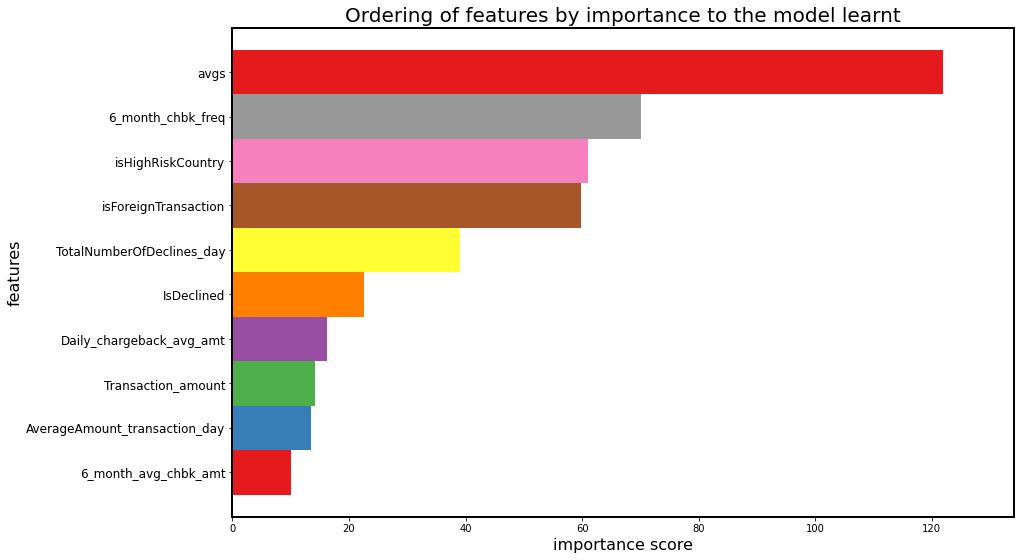

In [14]:
'''
The figure below shows that the new feature avgs that
we created isthe most relevant feature for the model.
The features are ordered based on the number of 
samples affected by splits on those features.
'''
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

In [15]:
model = XGBClassifier()
model.fit(trainX, trainY)

[18:29:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(testX)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(testY, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.35%


In [17]:
import pickle
file=open('minip.pkl','wb')
pickle.dump(model,file)
file.close()